# COMP5310 Project Stage II Code

Lecturer:  Dr Ali Anaissi 

Group members name and SID:

1. Dinh Nguyen Minh Dang     490457041
2. Mengting (Timi) YE        460250027


================================================================================================================

## DB connection

In [1]:
import psycopg2

def pgconnect():
    YOUR_PW = 'minhdang504'
    try: 
        conn = psycopg2.connect(host='localhost',
                                database='postgres',
                                user='postgres',
                                port= 5433,
                                password=YOUR_PW)
        print('connected')
    except Exception as e:
        print("unable to connect to the database")
        print(e)
    return conn

import psycopg2.extras

def pgquery( conn, sqlcmd, args, silent=False, returntype='tuple'):
   """ utility function to execute some SQL query statement
       it can take optional arguments (as a dictionary) to fill in for placeholder in the SQL
       will return the complete query result as return value - or in case of error: None
       error and transaction handling built-in (by using the 'with' clauses) """
   retval = None
   with conn:
      cursortype = None if returntype != 'dict' else psycopg2.extras.RealDictCursor     
      with conn.cursor(cursor_factory=cursortype) as cur:
         try:
            if args is None:
                cur.execute(sqlcmd)
            else:
                cur.execute(sqlcmd, args)
            retval = cur.fetchall() # we use fetchall() as we expect only _small_ query results
         except Exception as e:
            if e.pgcode != None and not(silent):
                print("db read error: ")
                print(e)
   return retval

## Data preparation

In [2]:
# Load libraries
import numpy
import pandas
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

# connect to your database
conn = pgconnect()
    
# prepare SQL statement
query_stmt ="""SELECT * FROM Melbourne;"""
# execute query and print result
query_result = pgquery (conn, query_stmt, None, returntype='dict')
# cleanup
conn.close()

dataset = pandas.DataFrame(query_result)
#dataset.to_csv(r'\cleanMelbourne.csv')
#print(dataset.iloc[0],'\n')
feature = dataset.drop(dataset.columns[[1, 4, 9, 10]], axis=1) #drop bed price propcount
#print(feature.iloc[0])
clas = dataset['price']

connected


## Spot checking algorithms

In [3]:
# Prepare Data

# Split-out validation dataset
X = feature.values
Y = clas.values
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# Evaluate Algorithms
# Test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'neg_mean_absolute_error'

# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = KFold(n_splits=num_folds, random_state=seed)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, -1*cv_results.mean(), cv_results.std())
	print(msg)

LR: 278432.267510 (13634.771961)
LASSO: 278431.594038 (13634.974565)
EN: 305497.036811 (16411.882831)
KNN: 295939.599358 (15490.903099)
CART: 227840.692822 (11684.724871)
SVR: 457485.199566 (16733.887103)


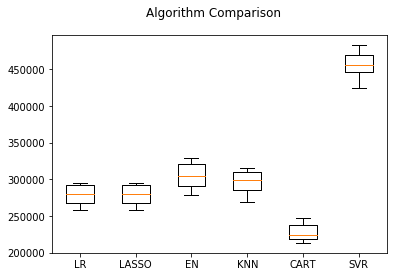

In [4]:
for i in range(len(results)):
    results[i]= -1*results[i]

# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Standardize and Spot checking algorithms

In [5]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))
results = []
names = []
for name, model in pipelines:
	kfold = KFold(n_splits=num_folds, random_state=seed)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, -1*cv_results.mean(), cv_results.std())
	print(msg)

ScaledLR: 278432.267510 (13634.771961)
ScaledLASSO: 278432.072380 (13634.781413)
ScaledEN: 288794.482761 (14303.985067)
ScaledKNN: 200528.543972 (12599.021807)
ScaledCART: 227922.461137 (13723.986082)
ScaledSVR: 457245.117102 (16733.665657)


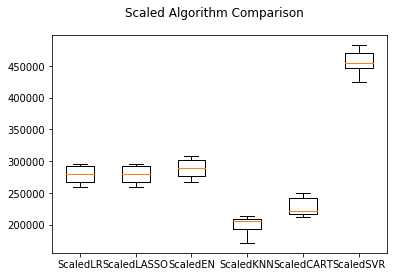

In [6]:
for i in range(len(results)):
    results[i]= -1*results[i]

# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Tuning KNN (best model)

In [7]:
# KNN Algorithm tuning
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
k_values = numpy.array([1,3,5,7,9,11,13,15,17,19,21])
param_grid = dict(n_neighbors=k_values)
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (-1*grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (-1*mean, stdev, param))

Best: 198046.283346 using {'n_neighbors': 13}
247236.832466 (12141.342257) with: {'n_neighbors': 1}
208629.136775 (11406.899400) with: {'n_neighbors': 3}
199979.334337 (12033.222056) with: {'n_neighbors': 5}
199015.428973 (12858.161815) with: {'n_neighbors': 7}
199036.554274 (12030.930210) with: {'n_neighbors': 9}
198589.856303 (12121.260307) with: {'n_neighbors': 11}
198046.283346 (11795.542834) with: {'n_neighbors': 13}
198615.738594 (11714.792265) with: {'n_neighbors': 15}
199196.564463 (11945.719308) with: {'n_neighbors': 17}
199205.867307 (11864.274469) with: {'n_neighbors': 19}
199840.420178 (12361.571544) with: {'n_neighbors': 21}


## Making prediction on validation set with KNN

In [8]:
# Make predictions on validation dataset
from sklearn.metrics import mean_absolute_error
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = KNeighborsRegressor(n_neighbors=13)
model.fit(rescaledX, Y_train)
# transform the validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)

print("Mean abs error: ", mean_absolute_error(Y_validation, predictions))

print("Validation set Price's mean: ", Y_validation.mean())

Mean abs error:  202496.67071904475
Validation set Price's mean:  1111283.835208099


## Ensembles Algorithm Testing

In [9]:
# ensembles
ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor())])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor())])))
results = []
names = []
for name, model in ensembles:
	kfold = KFold(n_splits=num_folds, random_state=seed)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, -1*cv_results.mean(), cv_results.std())
	print(msg)

ScaledAB: 447295.926447 (21288.179773)
ScaledGBM: 179048.220602 (10113.633938)
ScaledRF: 173470.009586 (9139.354254)
ScaledET: 171607.025517 (8794.726978)


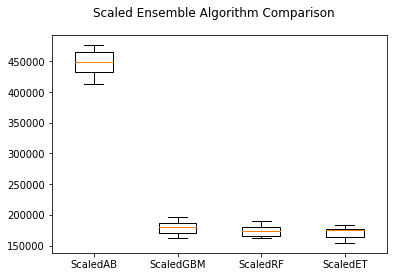

In [10]:
for i in range(len(results)):
    results[i]= -1*results[i]
    
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [11]:
# Tune scaled GBM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=numpy.array([50,100,150,200,250,300,350,400]))
model = GradientBoostingRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (-1*grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (-1*mean, stdev, param))

Best: 162972.636016 using {'n_estimators': 400}
192554.058077 (11476.002317) with: {'n_estimators': 50}
178992.310669 (10104.329399) with: {'n_estimators': 100}
173885.588326 (9136.972281) with: {'n_estimators': 150}
170256.679763 (8517.000703) with: {'n_estimators': 200}
167843.221959 (8310.639442) with: {'n_estimators': 250}
165828.644624 (8198.273520) with: {'n_estimators': 300}
164237.770459 (8142.820791) with: {'n_estimators': 350}
162972.636016 (7952.884711) with: {'n_estimators': 400}


In [12]:
# Make predictions on validation dataset

# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = GradientBoostingRegressor(random_state=seed, n_estimators=400)
model.fit(rescaledX, Y_train)
# transform the validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)

print("Mean absolute error: ", mean_absolute_error(Y_validation, predictions))
print("Validation set Price's mean: ", Y_validation.mean())

Mean absolute error:  167563.04999236725
Validation set Price's mean:  1111283.835208099


## THE END